## Постановка задачи

### Description

Вам предоставлен набор данных — некоторых вещественно значных признаков. Вам нужно проставить метки классов, другими словами кластеризовать данные.

### Evaluation

Метрика оценки качества — Adjusted Rand Score.

Ваш файл решения должен иметь следующий вид:

'''csv
ID,TARGET
0,0
1,1
2,2
3,3
4,4
...
'''

Данные — sparse матрица размера (14590, 77888).

### Files

train.npz - набор данных, по которым необходимо предсказать метки.

sample_submission.csv - пример файла решения

### Загрузка данных

from scipy import sparse

train = sparse.load_npz("train.npz")

### Подключение окружения

#### pip

In [1]:
!pip install scipy numpy pandas emot nltk wordsegment optuna pymorphy3 umap-learn pymorphy3-dicts-ru tqdm xgboost catboost scikit-learn matplotlib seaborn progressbar2

#### import

In [2]:
import numpy as np
import pandas as pd
import re
import warnings
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from progressbar import progressbar
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from tqdm import notebook
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, jaccard_score
from scipy import sparse
from sklearn.pipeline import make_pipeline
import umap.umap_ as umap
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from scipy.stats import kde

%matplotlib inline 

#### Полезные функции

In [3]:
def saveLabels(labels, filename='hw4_result.csv'):
    test_df = pd.read_csv("sample_submission.csv")
    test_df["TARGET"] = labels
    test_df[["ID", "TARGET"]].to_csv(filename, index=False)

In [4]:
def plotVision(metric, df, lbls=None):
    plt.figure(figsize=[16, 8])
    plt.subplot(1, 2, 1)
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=lbls )
    plt.title(metric)
    plt.grid()
    plt.subplot(1, 2, 2)
    sns.kdeplot(x=df[:, 0], y=df[:, 1], fill=True, thresh=0, levels=100, cmap="mako", cbar=False)
    plt.title('Карта плотностей')
    plt.show()

In [5]:
def plotKMeans(df, labels, model):
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1)
    centroids = model.cluster_centers_
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=labels )
    plt.scatter(centroids[:, 0], centroids[:, 1], linewidths=10, marker ="x", color='black')
    plt.subplot(1, 2, 2)
    sns.kdeplot(x=df[:, 0], y=df[:, 1], fill=True, thresh=0, levels=100, cmap="mako", cbar=False)
    plt.show()

In [6]:
def plotGMM(df, labels):
    plt.figure(figsize=[6, 6])
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=labels )
    plt.show()

In [7]:
def plotSCM(df, labels):
    plt.figure(figsize=[6, 6])
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=labels )
    plt.show()

## Подготовка данных

In [8]:
train = sparse.load_npz("train.npz")
X = train

In [9]:
X

<14590x77888 sparse matrix of type '<class 'numpy.float64'>'
	with 2026769 stored elements in Compressed Sparse Row format>

In [10]:
X.shape

(14590, 77888)

## Modeling

### Визуализация

#### PCA (SVD)

In [181]:
%%time
svd = TruncatedSVD(n_components=2)
svd_df = svd.fit_transform(X)

CPU times: user 2.59 s, sys: 2.03 s, total: 4.62 s
Wall time: 727 ms


In [182]:
svd_df

array([[ 0.09119625,  0.00166471],
       [ 0.09078268,  0.00872731],
       [ 0.08260834,  0.0035411 ],
       ...,
       [ 0.10094115, -0.00029439],
       [ 0.11317277,  0.02450893],
       [ 0.19189452,  0.02712839]])

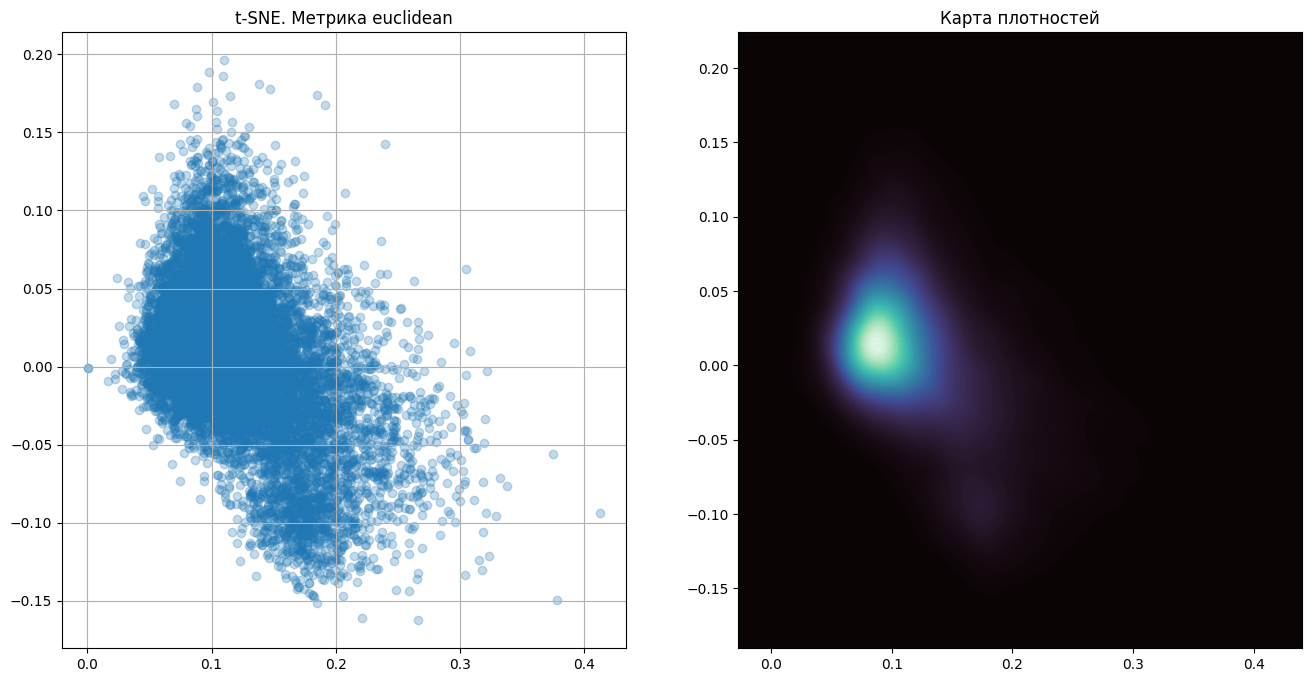

In [183]:
plotVision("t-SNE. Метрика euclidean", svd_df)

PCA(SVG) в данной задаче использовать будет не эффективно, так как колличество компонентов будет очень большим.

#### t-SNE

In [184]:
%%time
tsne = TSNE(n_components=3, perplexity=50, metric='euclidean', init='random', verbose=1)
tsne_df = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14590 samples in 0.003s...
[t-SNE] Computed neighbors for 14590 samples in 10.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14590
[t-SNE] Computed conditional probabilities for sample 2000 / 14590
[t-SNE] Computed conditional probabilities for sample 3000 / 14590
[t-SNE] Computed conditional probabilities for sample 4000 / 14590
[t-SNE] Computed conditional probabilities for sample 5000 / 14590
[t-SNE] Computed conditional probabilities for sample 6000 / 14590
[t-SNE] Computed conditional probabilities for sample 7000 / 14590
[t-SNE] Computed conditional probabilities for sample 8000 / 14590
[t-SNE] Computed conditional probabilities for sample 9000 / 14590
[t-SNE] Computed conditional probabilities for sample 10000 / 14590
[t-SNE] Computed conditional probabilities for sample 11000 / 14590
[t-SNE] Computed conditional probabilities for sample 12000 / 14590
[t-SNE] Computed conditional probabilities for s

In [185]:
tsne_df

array([[ 43.381958 , -10.48032  , -35.320633 ],
       [ 56.942074 ,  -4.280642 ,   2.3635736],
       [ 16.08215  ,   0.9376576, -60.686665 ],
       ...,
       [-23.225883 , -46.716583 ,  20.95754  ],
       [  8.018087 , -12.071188 , -14.804896 ],
       [ 18.544529 ,  14.045504 ,  -7.5563145]], dtype=float32)

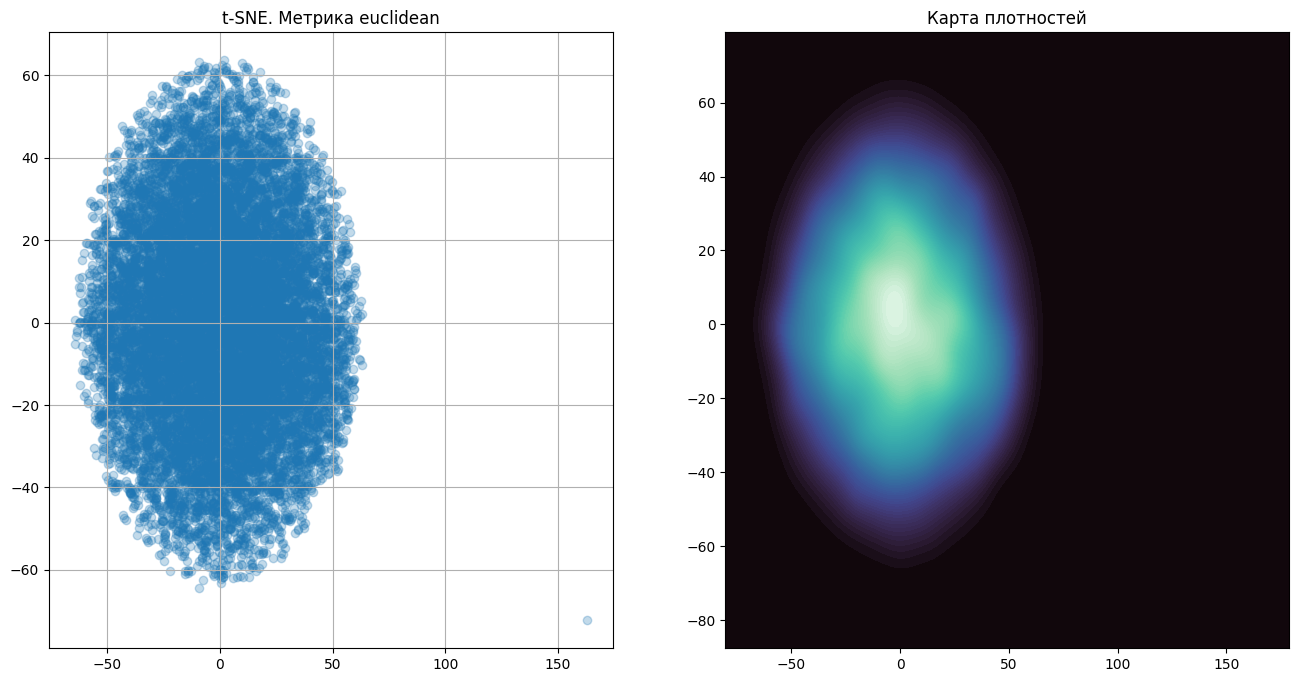

In [186]:
plotVision("t-SNE. Метрика euclidean", tsne_df)

#### UMAP

In [11]:
%%time
umapm = umap.UMAP(n_components=3, verbose=1)
umap_df = umapm.fit_transform(X)

UMAP(n_components=3, verbose=1)
Sat Apr 27 21:47:45 2024 Construct fuzzy simplicial set
Sat Apr 27 21:47:45 2024 Finding Nearest Neighbors
Sat Apr 27 21:47:45 2024 Building RP forest with 11 trees
Sat Apr 27 21:47:49 2024 metric NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	 8  /  14
	 9  /  14
	 10  /  14
	 11  /  14
	Stopping threshold met -- exiting after 11 iterations
Sat Apr 27 21:48:01 2024 Finished Nearest Neighbor Search
Sat Apr 27 21:48:03 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Apr 27 21:48:06 2024 Finished embedding
CPU times: user 1min 12s, sys: 1.76 s, total: 1min 14s
Wall time: 21.3 s


In [188]:
umap_df

array([[6.871833 , 7.0888987, 4.8188176],
       [9.439286 , 7.506594 , 3.2108524],
       [7.9416356, 7.086512 , 3.896848 ],
       ...,
       [8.938022 , 7.1953926, 4.887904 ],
       [7.8765035, 8.206417 , 2.9610753],
       [7.613787 , 9.601421 , 4.559547 ]], dtype=float32)

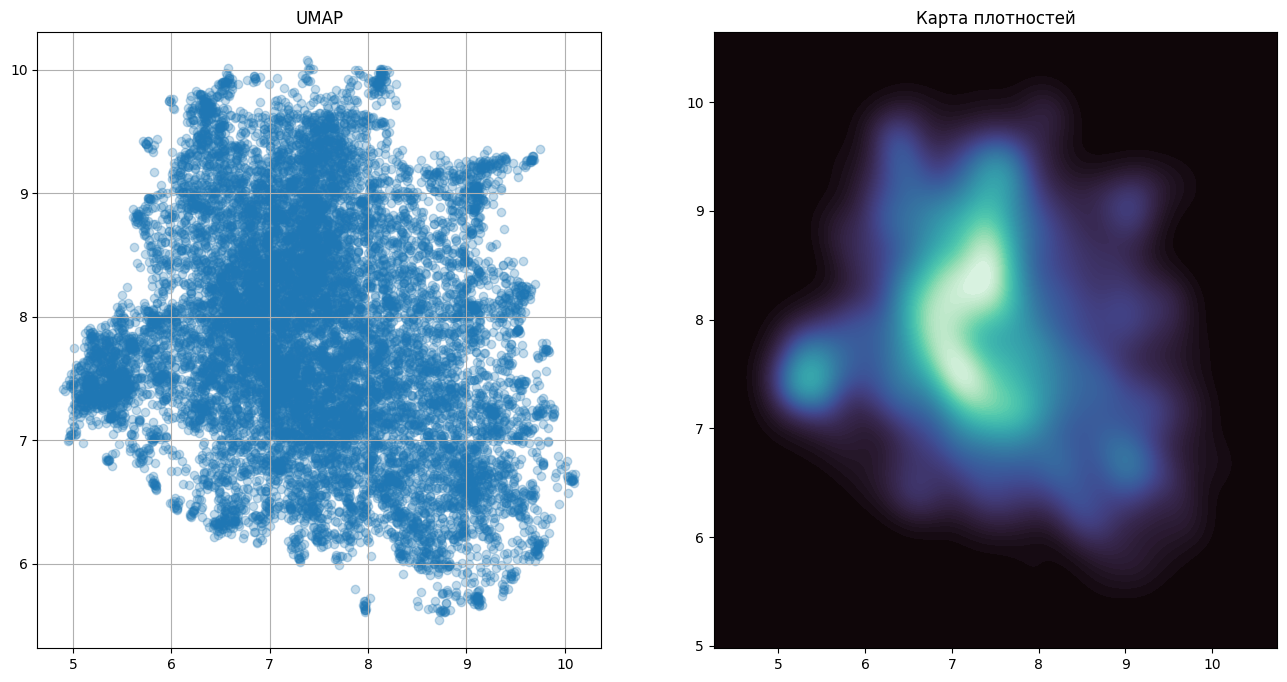

In [189]:
plotVision("UMAP", umap_df)

Видно, что формируется 2 скомпления точек, одно из которых больше другого. Есть отдельные скопления, но между ними есть заполненное пространство. При таком подходе алгоритмы кластеризации, использующие расстояния между точками, ничего хорошего выдавать не будут.

#### Метод локтя

Для трех наборов данных сделаем замеры метода локтя. Помимо колличества кластеров, мы так же сможет увидеть взаимосвязь между наборами данных

In [190]:
N = 20

In [191]:
crit_x = []
for k in progressbar(range(2, N)):
    kmeans = KMeans(n_clusters=k).fit(X)
    crit_x.append(np.sqrt(kmeans.inertia_))

100% (18 of 18) |########################| Elapsed Time: 0:00:18 Time:  0:00:180001


In [192]:
crit_tsne = []
for k in progressbar(range(2, 300)):
    kmeans = KMeans(n_clusters=k).fit(tsne_df)
    crit_tsne.append(np.sqrt(kmeans.inertia_))

100% (298 of 298) |######################| Elapsed Time: 0:00:39 Time:  0:00:390003


In [193]:
crit_umpa = []
for k in progressbar(range(2, N)):
    kmeans = KMeans(n_clusters=k).fit(umap_df)
    crit_umpa.append(np.sqrt(kmeans.inertia_))

100% (18 of 18) |########################| Elapsed Time: 0:00:00 Time:  0:00:000000


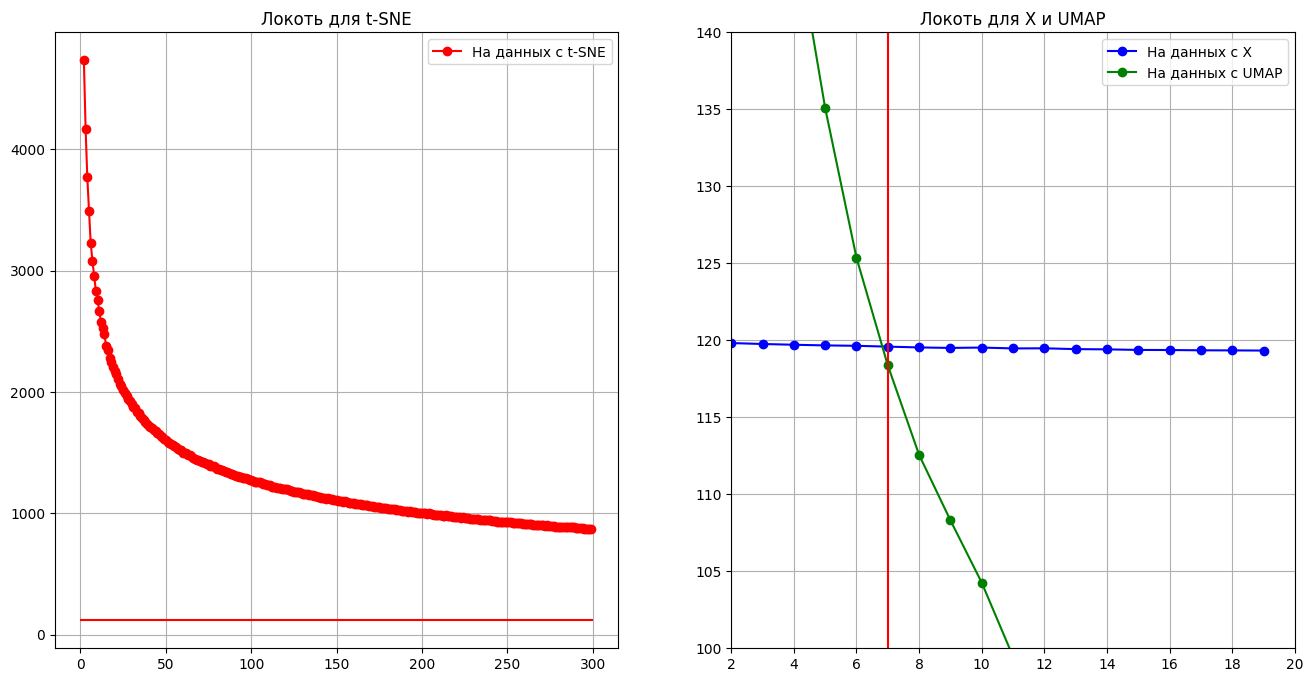

In [225]:
plt.figure(figsize=[16, 8])

plt.subplot(1, 2, 1)
plt.plot(range(2, 300), crit_tsne, 'o-r', label='На данных c t-SNE')
plt.title('Локоть для t-SNE')
plt.hlines(120, 0, 300, 'r')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Локоть для X и UMAP')
plt.plot(range(2, N), crit_x, 'o-b', label='На данных с X')
plt.plot(range(2, N), crit_umpa, 'o-g', label='На данных с UMAP')
plt.vlines(7, 50, 220, 'r')
plt.xlim(2, N)
plt.ylim(100, 140)
plt.grid()
plt.legend()
plt.show()

По графикам можно сказать, что UMAP можно наложить на изначальный данные. В то время как у t-SNE Слишком искажены. Колличество кластеров 7. В дальнейшем, для обчучения будем использовать **umap_df**

### Кластеризируем

#### Выбор моделей для анализа

Посмотрим еще раз на данные

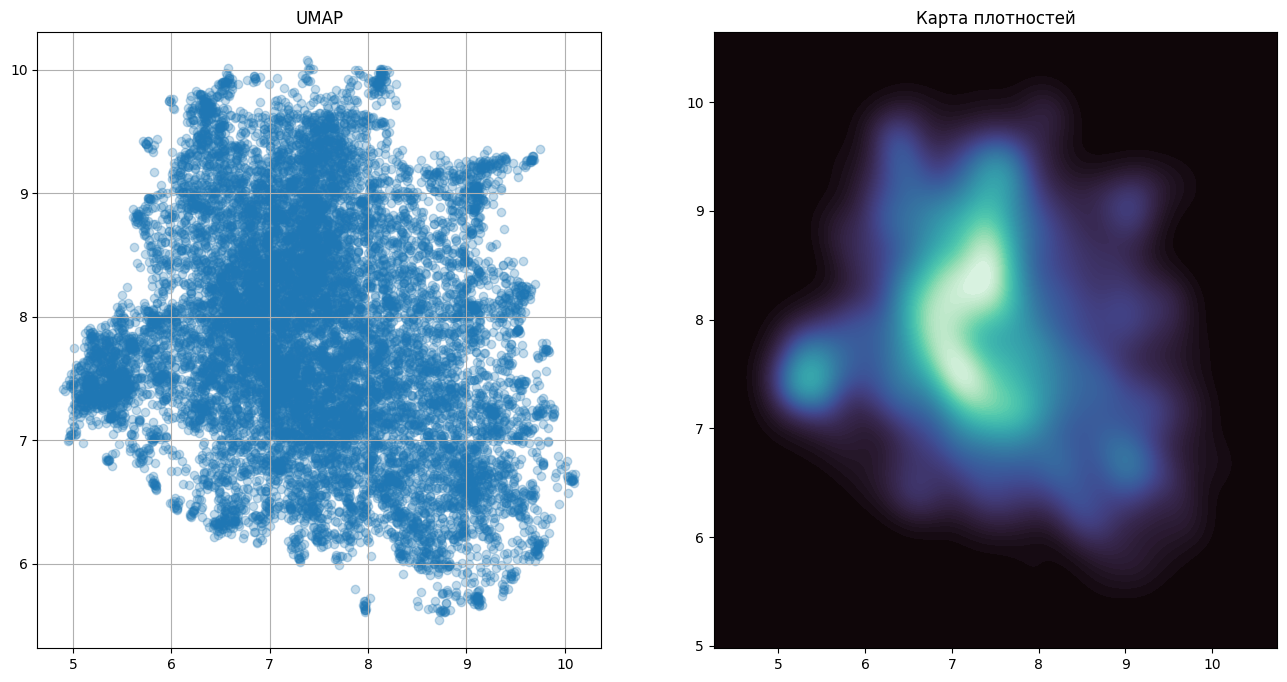

In [195]:
plotVision("UMAP", umap_df)

Используем для оценки KMeans, GaussianMixture и SpectralClustering

![](https://scikit-learn.ru/wp-content/uploads/2021/01/sphx_glr_plot_cluster_comparison_0011-2048x1219.png)

#### KMeans

##### firstlaunch

In [196]:
km = KMeans(n_clusters=7, algorithm='lloyd', init='random', max_iter=500, tol=1e-05)

In [197]:
%%time
km_labels = km.fit_predict(umap_df)
km_labels

CPU times: user 581 ms, sys: 520 ms, total: 1.1 s
Wall time: 185 ms


array([2, 1, 1, ..., 1, 6, 5], dtype=int32)

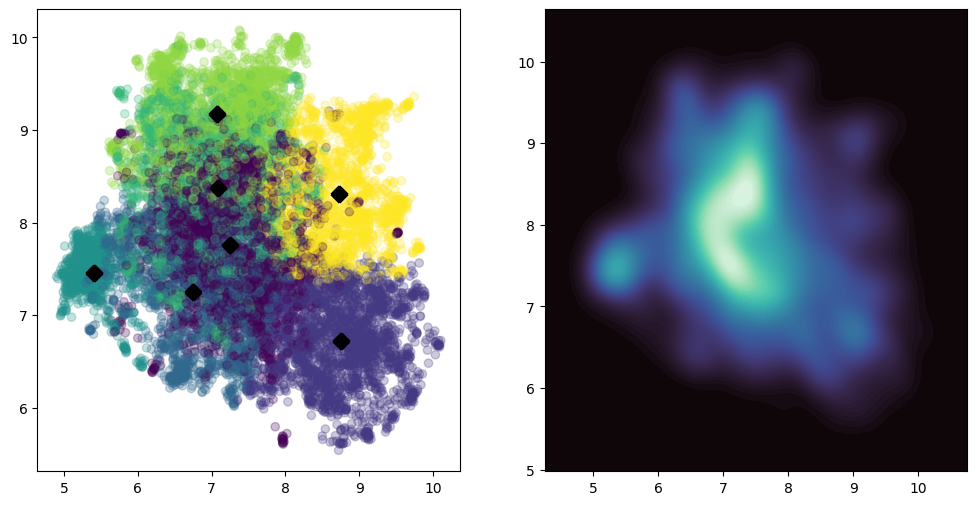

In [198]:
plotKMeans(umap_df, km_labels, km)

In [226]:
saveLabels(km_labels)

Результат получается: 0.05479182076353936

##### Попробуем поиграть с параметрами

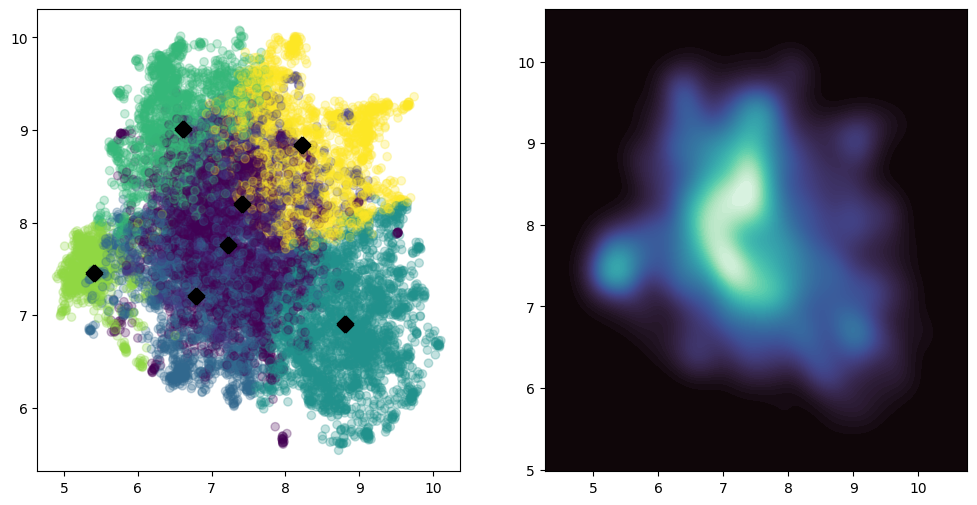

In [200]:
km_param = KMeans(n_clusters=7, algorithm='lloyd', init='k-means++', max_iter=1000).fit(umap_df)
km_param_labels = km_param.predict(umap_df)
plotKMeans(umap_df, km_param_labels, km_param)

In [228]:
saveLabels(km_param_labels)

Результат: 0.062187433135184475

Эффекта особого нету...

##### Попробуем взять по чистым данным

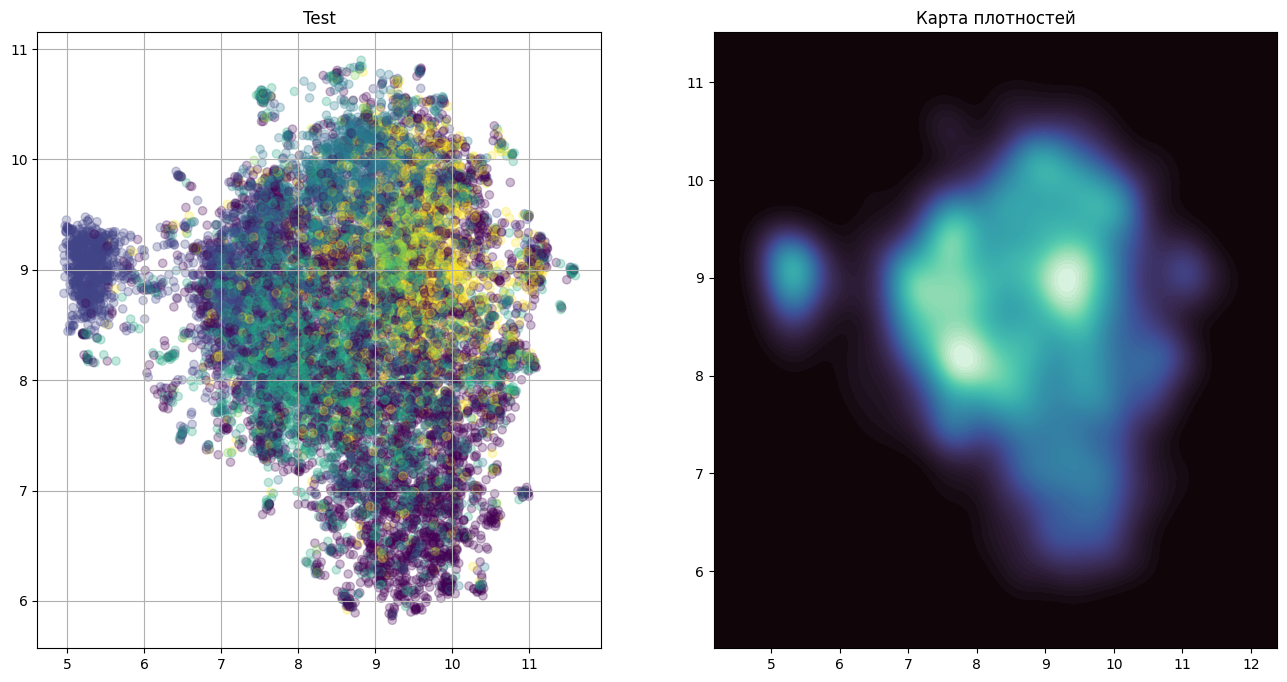

In [15]:
km_param_X = KMeans(n_clusters=6, algorithm='lloyd', init='random', max_iter=1000)
km_param_X.fit(X)
km_param_X_labels = km_param_X.predict(X)
plotVision( "Test", umap_df, km_param_X_labels)

KMeans - это метод кластеризации, который часто используется для разделения данных на группы на основе их сходства. Результаты кластеризации могут отличаться в зависимости от входных данных.

UMAP (Uniform Manifold Approximation and Projection) - это метод снижения размерности и визуализации данных, который помогает сохранить глобальную структуру данных. Он может изменить распределение точек в пространстве, что влияет на результаты работы KMeans.

Из-за этого разница в результатах кластеризации между оригинальными данными и данными после обработки UMAP вполне естественна.

In [14]:
saveLabels(km_param_X_labels, "hw4_result_km_param_X_labels.csv")

Лучший результат был: 0.08632642628354781

#### GaussianMixture

##### firstlaunch

In [204]:
gmm = GaussianMixture(n_components=7)

In [205]:
gmm_labels = gmm.fit_predict(umap_df)

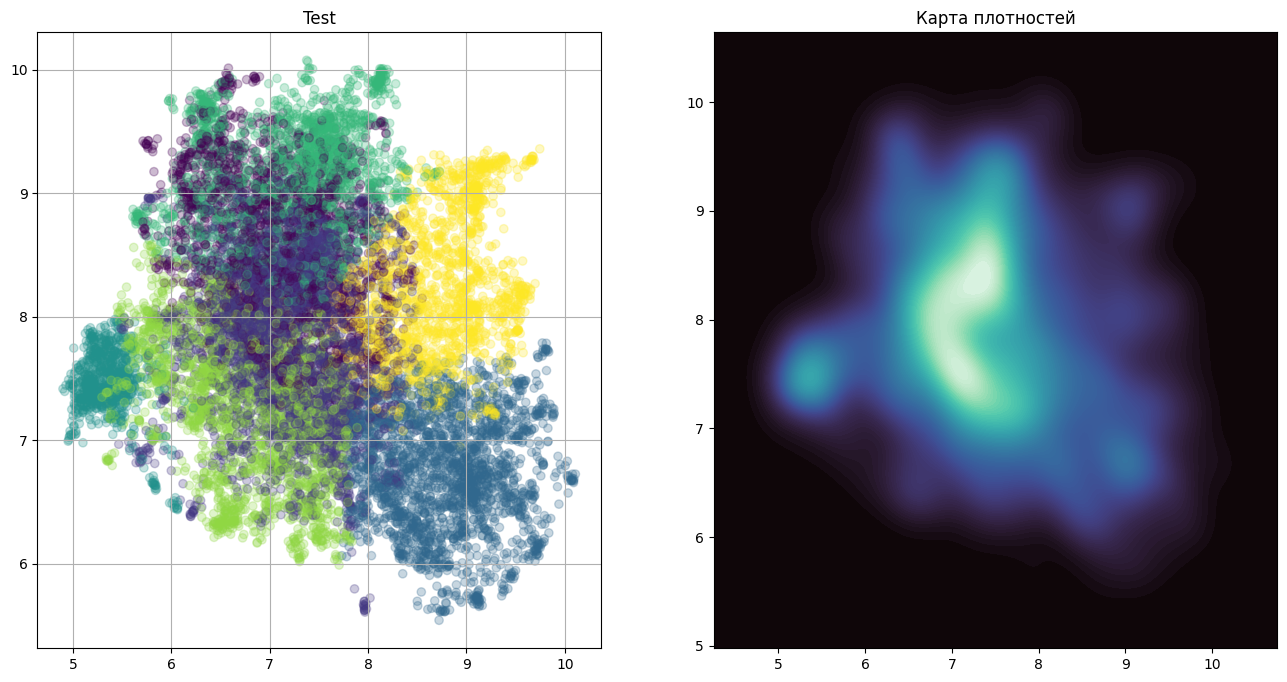

In [206]:
plotVision("Test", umap_df, gmm_labels)

##### Подберем параметры

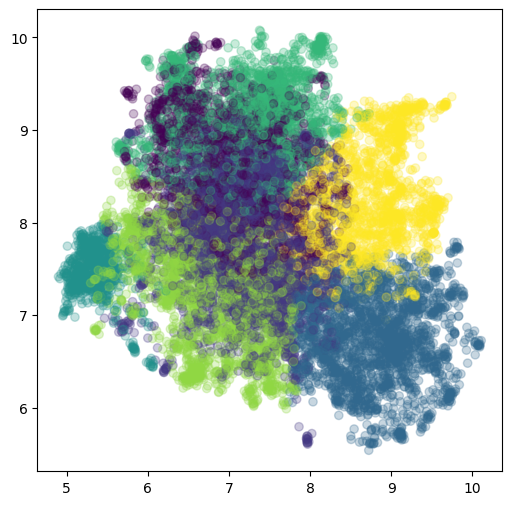

In [207]:
gmm_param_labels = GaussianMixture(n_components=7, covariance_type='spherical', tol=1e-6,
                                   init_params='kmeans', max_iter=1000, 
                                   random_state=42).fit_predict(umap_df)
plotGMM(umap_df, gmm_labels)

В целом подбор параметров вообще ничего не поменял. Более того результат похож на KMeans +-

In [208]:
saveLabels(gmm_labels)

##### Попробуем по чистым параметрам

In [209]:
# gmm_X_labels = GaussianMixture(n_components=7, verbose=1).fit_predict(X_array)

Плохая идея передавать массив целиком, моя система упала...

##### BayesianGaussianMixture

/opt/homebrew/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


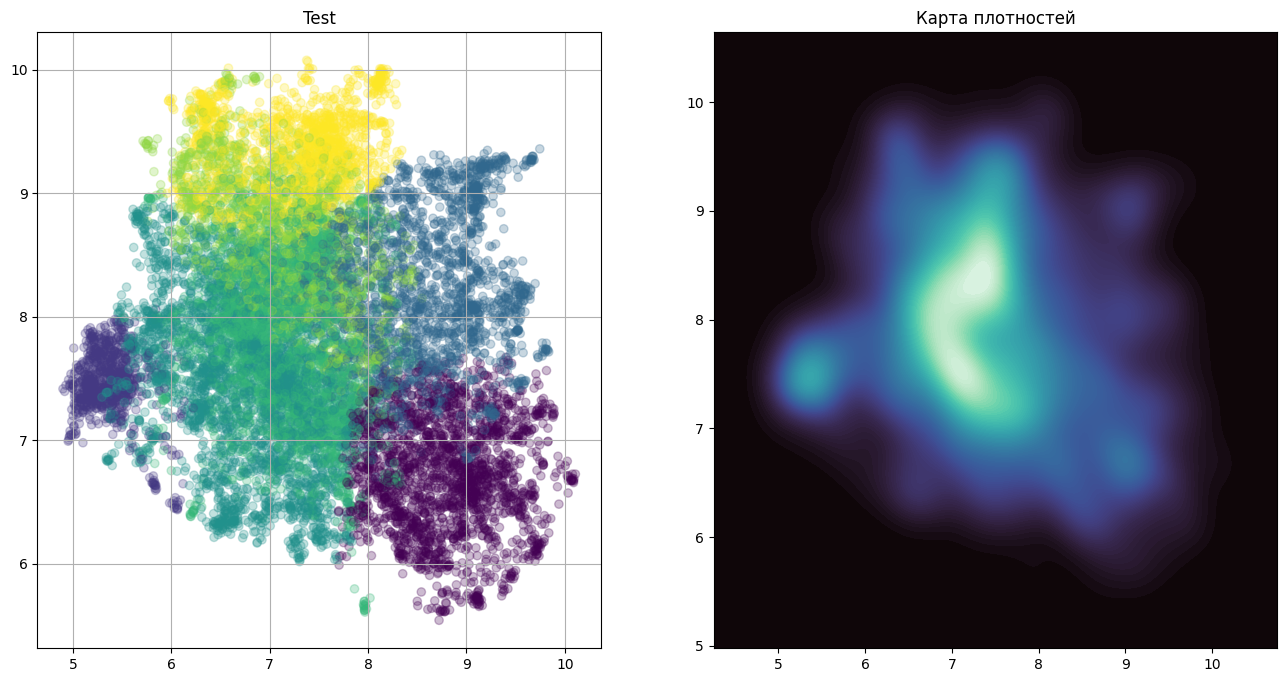

In [210]:
bgmm_labels = BayesianGaussianMixture(n_components=7).fit_predict(umap_df)
plotVision("Test", umap_df, bgmm_labels)

In [211]:
saveLabels(bgmm_labels, 'hw4_bgmm_labels.csv')

Результат: 0.06299464752618693

Интересный результат, в целом он схож с плотностью +-

/opt/homebrew/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


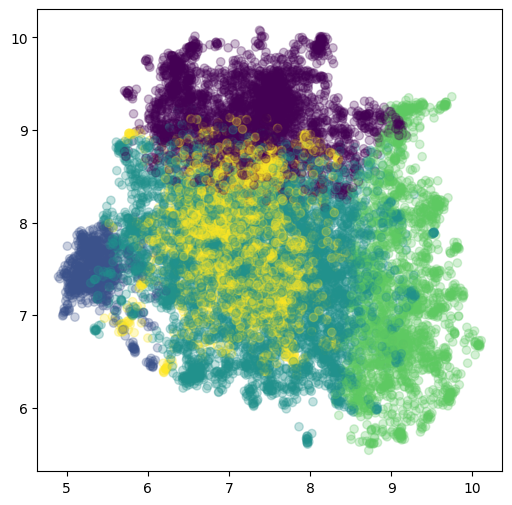

In [231]:
bgmm_param_labels = BayesianGaussianMixture(n_components=5, tol=1e-6, init_params='random',
                                            max_iter=500).fit_predict(umap_df)
plotGMM(umap_df, bgmm_param_labels)

In [233]:
saveLabels(bgmm_param_labels)

Результат: 0.09066487216027241

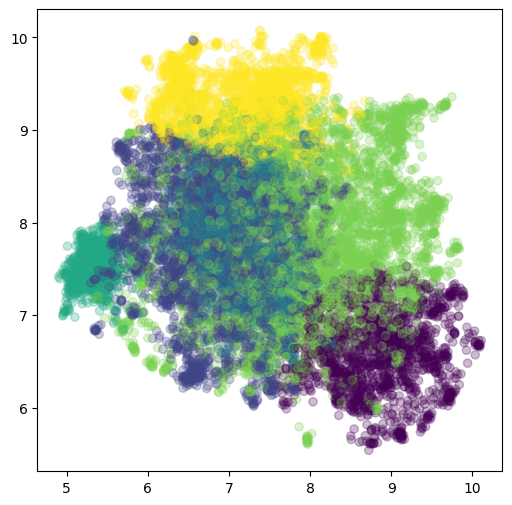

In [235]:
bgmm_param_labels_1 = BayesianGaussianMixture(n_components=6, tol=1e-1, init_params='random',
                                              max_iter=1000).fit_predict(umap_df)
plotGMM(umap_df, bgmm_param_labels_1)

In [236]:
saveLabels(bgmm_param_labels_1)

Результат: 0.0515428929266775

В целом модель дает интересные результаты, надо будет их проверить.

GMM не оправдала ожиданий

#### SpectralClustering

##### firstlaunch

In [248]:
scm = SpectralClustering(n_components=6)

In [249]:
%%time
scm_labels = scm.fit_predict(umap_df)

CPU times: user 1min 41s, sys: 25.7 s, total: 2min 7s
Wall time: 24.2 s


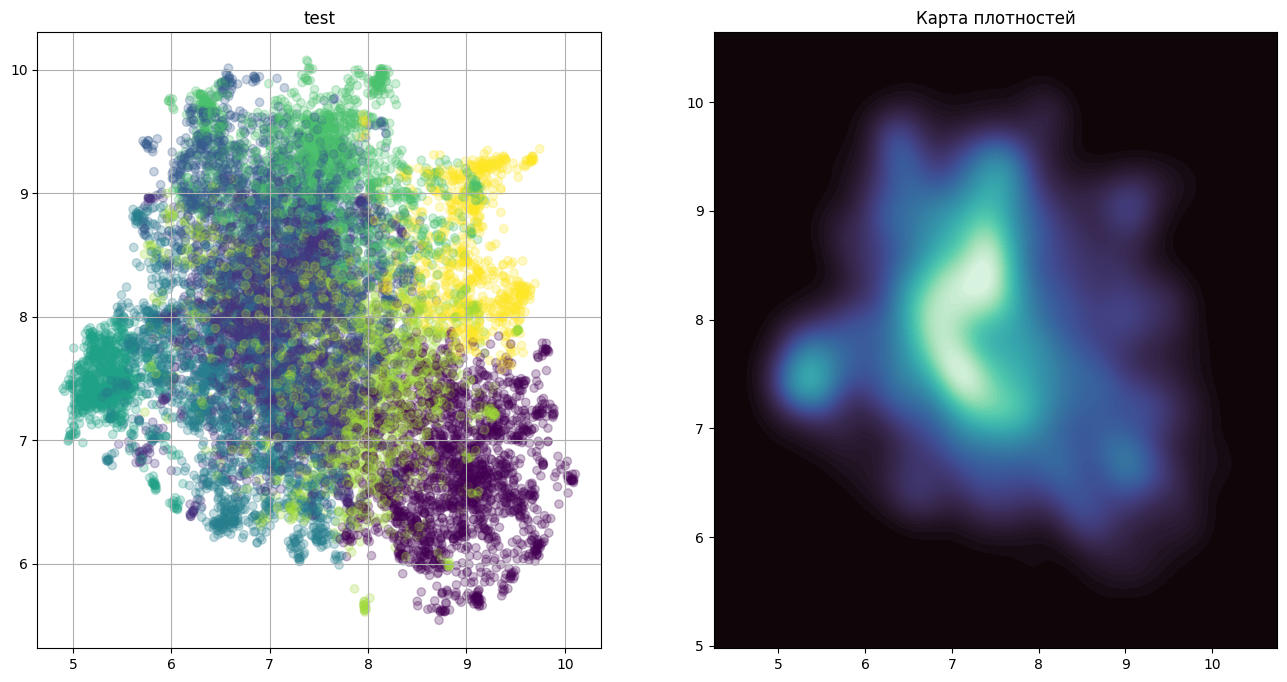

In [250]:
plotVision("test", umap_df, scm_labels)

In [251]:
saveLabels(scm_labels)

Результат: 0.04811854653338116

Результат похож на BayesianGaussianMixture(). Надо играть с параметрами

##### SpectralClustering с параметрами

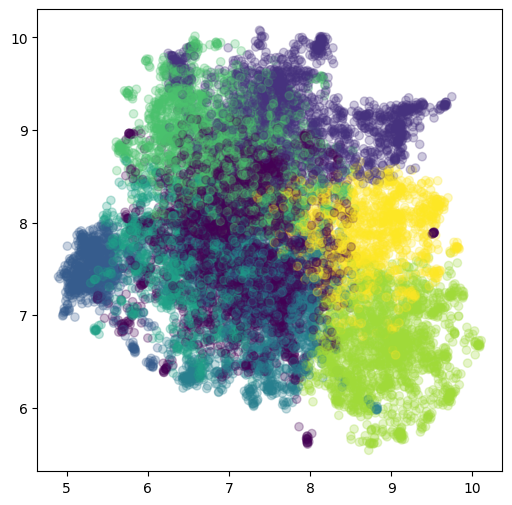

In [220]:
scm_param_labels_0 = SpectralClustering(n_components=5, eigen_solver=None, 
                                        gamma=1.0, n_neighbors=8, assign_labels='kmeans', 
                                        random_state=42).fit_predict(umap_df)
plotSCM(umap_df, scm_param_labels_0)

In [238]:
saveLabels(scm_param_labels_0)

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


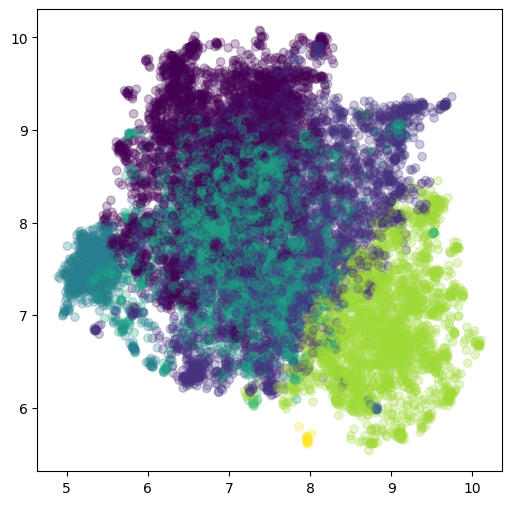

In [221]:
scm_param_labels_1 = SpectralClustering(n_components=6, eigen_solver=None, affinity='nearest_neighbors', 
                                        gamma=1.0, n_neighbors=8, assign_labels='kmeans', 
                                        random_state=42).fit_predict(umap_df)
plotSCM(umap_df, scm_param_labels_1)

In [222]:
saveLabels(scm_param_labels_1)

Результат: 0.06228887150891589

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


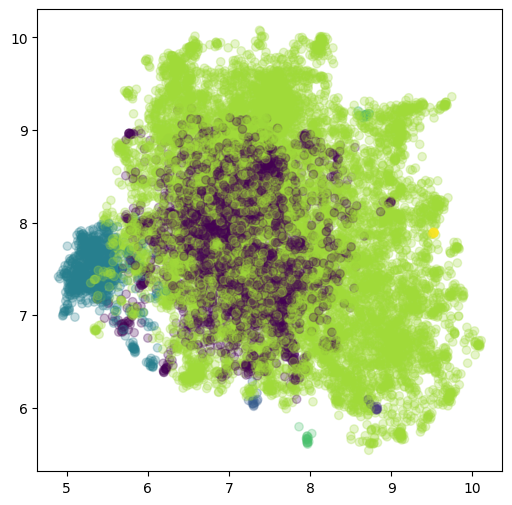

In [247]:
scm_param_labels_0 = SpectralClustering(n_components=5, eigen_solver=None, affinity='nearest_neighbors', 
                                        gamma=10.0, n_neighbors=8, assign_labels='kmeans', 
                                        random_state=42).fit_predict(umap_df)
plotSCM(umap_df, scm_param_labels_0)

Результат: **-0.03361968001421324**

### Best

In [241]:
best_score_df = pd.read_csv("score_best.csv")
best_score = np.array(best_score_df['TARGET'])
best_score

array([3, 4, 3, ..., 3, 2, 2])

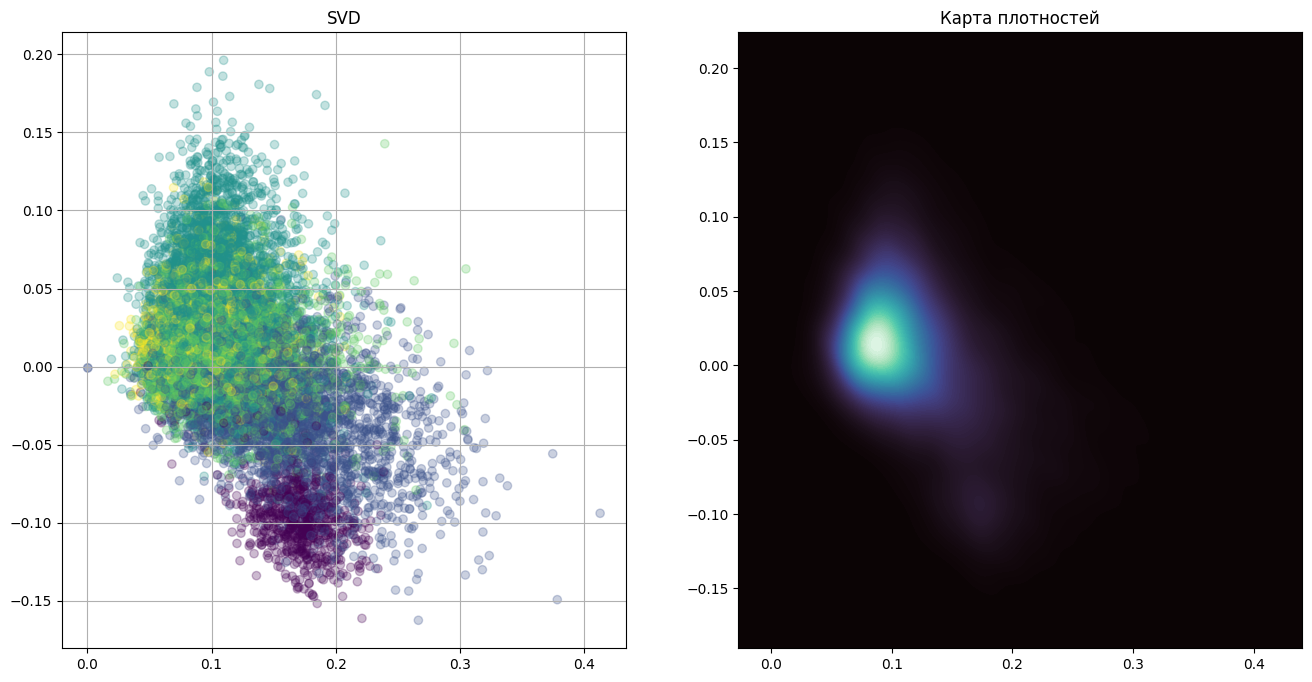

In [242]:
plotVision("SVD", svd_df, best_score)

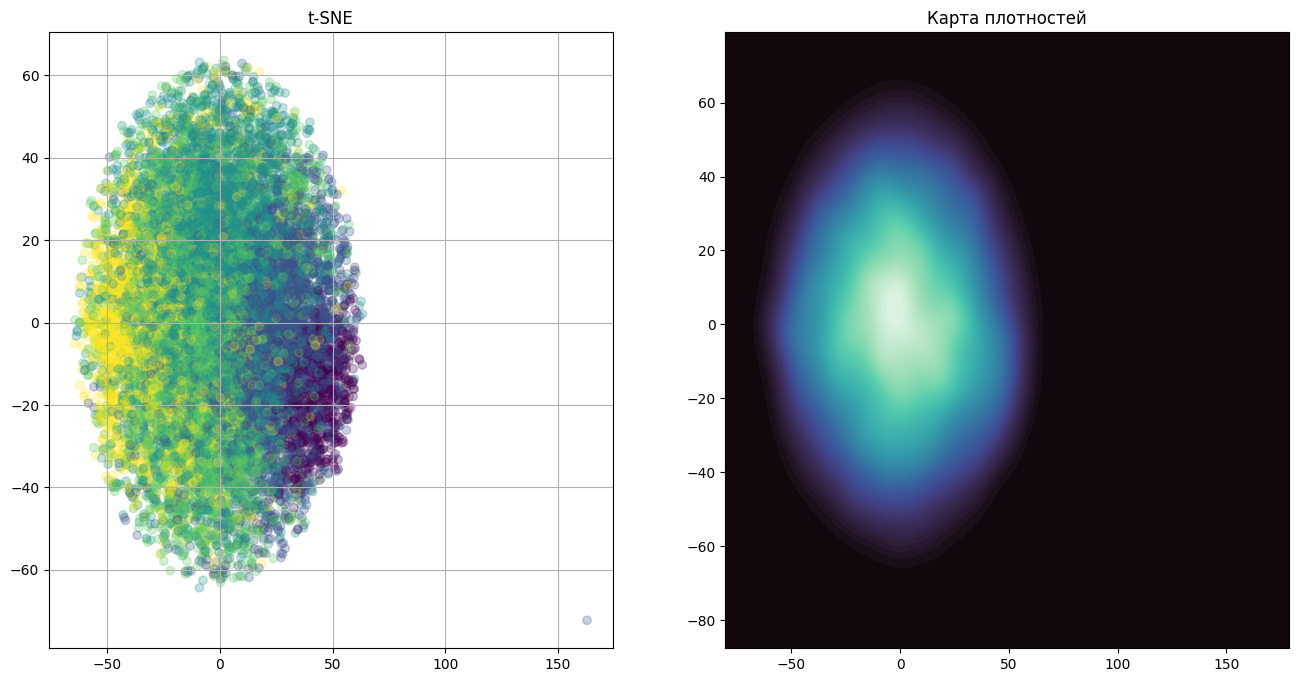

In [243]:
plotVision("t-SNE", tsne_df, best_score)

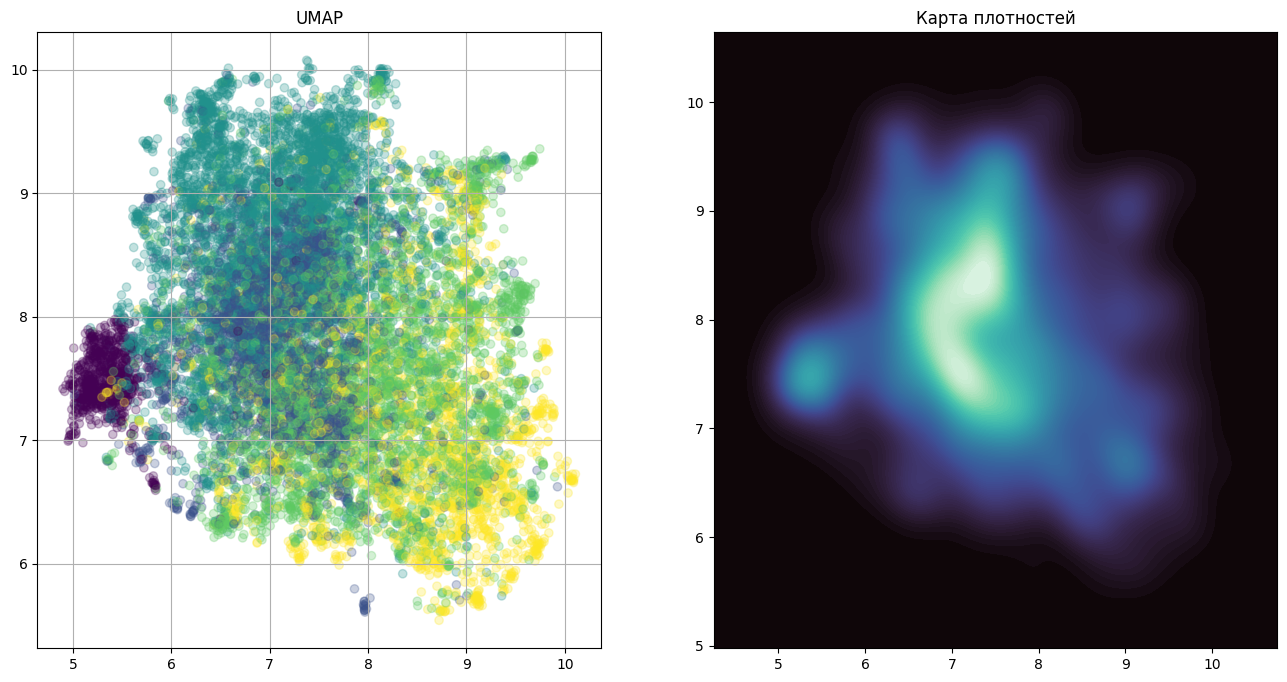

In [244]:
plotVision("UMAP", umap_df, best_score)